# Chap15 - 오토인코더 - Autoencoder


저번 포스팅 [07. 순환 신경망, RNN](http://excelsior-cjh.tistory.com/183)에서는 자연어, 음성신호, 주식과 같은 연속적인 데이터에 적합한 모델인 RNN, LSTM, GRU에 대해 알아보았다. 이번 포스팅에서는 딥러닝에서의 비지도 학습(unsupervised learning)이라고 할 수 있는 **오코인코더**(autoencoder)에 대해 알아보도록 하자.

## 1. 오토인코더 란?

오토인코더(Autoencoder)는 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경망이다. 어떻게 보면 간단한 신경망처럼 보이지만 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망으로 만든다. 예를들어 아래 그림처럼 hidden layer의 뉴런 수를 input layer(입력층) 보다 작게해서 데이터를 압축(차원을 축소)한다거나, 입력 데이터에 노이즈(noise)를 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 학습시키는 등 다양한 오토인코더가 있다. 이러한 제약들은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 방지하며, 데이터를 효율적으로 표현(representation)하는 방법을 학습하도록 제어한다.



![](./images/ae01.png)



오토인코더는 위의 그림에서 볼 수 있듯이 항상 인코더(encoder)와 디코더(decoder), 두 부분으로 구성되어 있다.

- **인코더(encoder)** : 인지 네트워크(recognition network)라고도 하며, 입력을 내부 표현으로 변환한다.
- **디코더(decoder)** : 생성 네트워크(generative nework)라고도 하며, 내부 표현을 출력으로 변환한다.

오토인코더는 위의 그림에서 처럼, 입력과 출력층의 뉴런 수가 동일하다는 것만 제외하면 일반적인 MLP(Multi-Layer Perceptron)과 동일한 구조이다. 오토인코더는 입력을 재구성하기 때문에 출력을 **재구성(reconstruction)**이라고도 하며, 손실함수는 입력과 재구성(출력)의 차이를 가지고 계산한다. 

위 그림의 오토인토더는 히든 레이어의 뉴런(노드, 유닛)이 입력층보다 작으므로 입력이 저차원으로 표현되는데, 이러한 오토인코더를 **Undercomplete Autoencoder**라고 한다. undercomplete 오토인코더는 저차원을 가지는 히든 레이어에 의해 입력을 그대로 출력으로 복사할 수 없기 때문에, 출력이 입력과 같은 것을 출력하기 위해 학습해야 한다. 이러한 학습을 통해 undercomplete 오토인코더는 입력 데이터에서 가장 중요한 특성(feature)을 학습하도록 만든다.

In [2]:
import os, sys
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

### functions for plotting

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## 2. Undercomplete Linear 오토인코더로 PCA 구현하기

위에서 살펴본 Undercomplete 오토인코더에서 활성화 함수를 sigmoid, ReLU같은 비선형(non-linear)함수가 아니라 선형(linear) 함수를 사용하고, 손실함수로 MSE(Mean Squared Error)를 사용할 경우에는 [PCA](http://excelsior-cjh.tistory.com/167?category=918734)라고 볼 수 있다.

아래의 예제코드는 가상의 3차원 데이터셋을 undercomplete 오토인코더를 사용해 2차원으로 축소하는 PCA를 수행한 코드이다.

In [4]:
# 3D 데이터셋을 만듦
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [5]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
reset_graph()

################
# layer params #
################
n_inputs = 3
n_hidden = 2  # coding units
n_outputs = n_inputs

# autoencoder
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

################
# Train params #
################
learning_rate = 0.01
n_iterations = 1000
pca = hidden

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # MSE
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(reconstruction_loss)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        train_op.run(feed_dict={X: X_train})
    pca_val = pca.eval(feed_dict={X: X_test})

In [7]:
# fig = plt.figure(figsize=(4,3))
# plt.plot(pca_val[:,0], pca_val[:, 1], "b.")
# plt.xlabel("$z_1$", fontsize=18)
# plt.ylabel("$z_2$", fontsize=18, rotation=0)
# print('pca_val.shape :', pca_val.shape)
# plt.show()

![](./images/unc-ae.PNG)



위의 코드에서 입력의 개수(`n_inputs`)와 출력의 개수(`n_outputs`)가 동일한 것을 알 수 있으며, PCA를 위해 `tf.layers.dense()`에서 따로 활성화 함수를 지정해주지 않아 모든 뉴런이 선형인 것을 알 수 있다. 

## 3. Stacked 오토인코더

**Stacked** 오토인코더 또는 **deep** 오토인코더는 여러개의 히든 레이어를 가지는 오토인코더이며, 레이어를 추가할수록 오토인코더가 더 복잡한 코딩(부호화)을 학습할 수 있다. stacked 오토인코더의 구조는 아래의 그림과 같이 가운데 히든레이어(코딩층)을 기준으로 대칭인 구조를 가진다.

![stacked autoencoder](./images/stacked-ae.PNG)

### 3.1 텐서플로로 stacked 오토인코더 구현

Stacked 오토인코더는 기본적인 Deep MLP와 비슷하게 구현할 수 있다. 아래의 예제는 [He](http://excelsior-cjh.tistory.com/177?category=940400) 초기화, [ELU](http://excelsior-cjh.tistory.com/178?category=940400) 활성화 함수, $l_2$ 규제(regularization)을 사용해 MNIST 데이터셋에 대한 stacked 오토인코더를 구현한 코드이다.

#### 3.1.1 MNIST Data Load

In [8]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.0
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.0
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [9]:
reset_graph()

from functools import partial

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
he_init = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)  # L2 규제
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

# stacked autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Saver
saver = tf.train.Saver(max_to_keep=1)

In [10]:
%%time
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae.ckpt')

epoch : 0, Train MSE : 0.02316
epoch : 1, Train MSE : 0.01119
epoch : 2, Train MSE : 0.01046
epoch : 3, Train MSE : 0.01036
epoch : 4, Train MSE : 0.01053
CPU times: user 5.46 s, sys: 188 ms, total: 5.64 s
Wall time: 4.69 s


In [11]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={inputs: test_x[:n_test_digits]})

    fig = plt.figure(figsize=(10, 4))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(test_x[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
# show_reconstructed_digits(inputs, outputs, './model/stacked_ae.ckpt')

위의 코드를 학습 시킨 후에 테스트셋의 일부를 재구성하였을 때, 아래의 그림과 같은 결과가 나온다.

![](./images/stacked-ae02.PNG)

### 3.2 가중치 묶기

위(3.1)에서 구현한 stacked 오토인코더처럼, 오토인코더가 완전히 대칭일 때에는 일반적으로 인코더(encoder)의 가중치와 디코더(decoder)의 가중치를 묶어준다. 이렇게 가중치를 묶어주게 되면, 네트워크의 가중치 수가 절반으로 줄어들기 때문에 학습 속도를 높이고 오버피팅의 위험을 줄여준다.

![](./images/stacked-ae03.PNG)



위의 그림을 수식으로 나타내면, 예를들어 오토인코더가 $N$개의 층을 가지고 있고 $\mathbf{W}_L$ 이 $L$ 번째 층의 가중치를 나타낸다고 할 때, 디코더 층의 가중치는 $\mathbf{W}_{N-L+1} = \mathbf{W}_{L}^{T}$로 정의할 수 있다. 

In [12]:
reset_graph()

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0005
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
activation = tf.nn.elu
weight_initializer = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)  # L2 규제

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

W1_init = weight_initializer([n_inputs, n_hidden1])
W2_init = weight_initializer([n_hidden1, n_hidden2])

# Encoder weights
W1 = tf.Variable(W1_init, dtype=tf.float32, name='W1')
W2 = tf.Variable(W2_init, dtype=tf.float32, name='W2')
# Decoder weights
W3 = tf.transpose(W2, name='W3')  # 가중치 묶기
W4 = tf.transpose(W1, name='W4')  # 가중치 묶기

# bias
b1 = tf.Variable(tf.zeros(n_hidden1), name='b1')
b2 = tf.Variable(tf.zeros(n_hidden2), name='b2')
b3 = tf.Variable(tf.zeros(n_hidden3), name='b3')
b4 = tf.Variable(tf.zeros(n_outputs), name='b4')

hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_loss = l2_regularizer(W1) + l2_regularizer(W2)
loss = reconstruction_loss + reg_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

In [13]:
%%time
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae_tying.ckpt')

epoch : 0, Train MSE : 0.01495
epoch : 1, Train MSE : 0.01514
epoch : 2, Train MSE : 0.01716
epoch : 3, Train MSE : 0.01761
epoch : 4, Train MSE : 0.01720
CPU times: user 5.32 s, sys: 160 ms, total: 5.48 s
Wall time: 4.64 s


INFO:tensorflow:Restoring parameters from ./model/stacked_ae_tying.ckpt


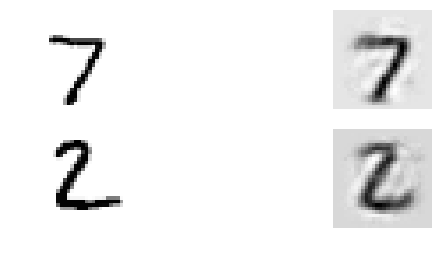

In [14]:
show_reconstructed_digits(inputs, outputs, './model/stacked_ae_tying.ckpt')

### 3.3 한 번에 한 층씩 학습하기

3.1과 3.2에서 처럼 한 번에 전체 오토인코더를 학습시키는 것보다 아래의 그림처럼 한 번에 오토인코더 하나를 학습하고, 이를 쌓아올려서 한 개의 stacked-오토인코더를 만드는 것이 훨씬 빠르며 이러한 방식은 아주 깊은 오토인코더일 경우에 유용하다.

![](./images/stacked-ae04.PNG)



- [단계 1]에서 첫 번째 오토인코더는 입력을 재구성하도록 학습된다.
- [단계 2]에서는 두 번째 오토인코더가 첫 번째 히든 레이어(`Hidden 1`)의 출력을 재구성하도록 학습된다.

- [단계 3]에서는 단계1 ~ 2의 오토인코더를 합쳐 최종적으로 하나의 stacked-오토인코더를 구현한다.


텐서플로에서 이렇게 여러 단계의 오토인코더를 학습시키는 방법으로는 다음과 같이 두 가지 방법이 있다.

-  각 단계마다 다른 텐서플로 그래프(graph)를 사용하는 방법
- 하나의 그래프에 각 단계의 학습을 수행하는 방법

#### 3.3.1 여러개의 그래프에서 오토인코더 학습하기

각 오토인코더를 다른 그래프를 사용하여 학습한다. 그런 다음 이런 오토인코더의 가중치와 편향을 복사해 초깃값으로 지정해서 적층 오토인코더를 만든다.

In [15]:
from functools import partial

reset_graph()

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

def train_autoencoder(train_x, n_neurons, n_epochs, batch_size, 
                      learning_rate=0.01, l2_reg=0.0005, seed=42,
                      hidden_activation=tf.nn.elu, 
                      output_activation=tf.nn.elu):

    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = train_x.shape[1]
        
        inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.keras.initializers.he_normal(), 
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = dense_layer(inputs, n_neurons, activation=hidden_activation, name='hidden')
        outputs = dense_layer(hidden, n_inputs, activation=output_activation, name='outputs')
        
        reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        n_batches = len(train_x) // batch_size
        for epoch in range(n_epochs):
            batch_x = None
            for iteration in range(n_batches):
                batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
                sess.run(train_op, feed_dict={inputs: batch_x})
            loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
            print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
            
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={inputs: train_x})
        
    return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

#### 단계 1

In [16]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(train_x, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)

epoch : 0, Train MSE : 0.01839
epoch : 1, Train MSE : 0.01773
epoch : 2, Train MSE : 0.01953
epoch : 3, Train MSE : 0.01933


#### 단계 2

In [17]:
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

epoch : 0, Train MSE : 0.00432
epoch : 1, Train MSE : 0.00468
epoch : 2, Train MSE : 0.00470
epoch : 3, Train MSE : 0.00448


#### 단계 3

In [18]:
reset_graph()

n_inputs = 28*28

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(inputs, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

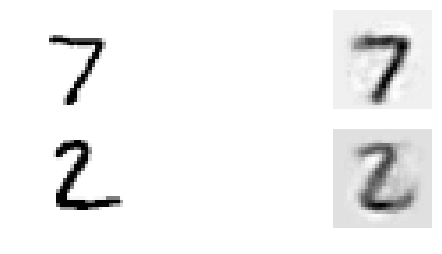

In [19]:
show_reconstructed_digits(inputs, outputs)

#### 3.3.2 하나의 그래프에서 오토인코더를 각각 학습하기

전체 적층 오토인코더를 위한 그래프를 만들지만 각 오토인코더를 독립적으로 학습하기 위한 연산도 추가합니다. 단계 1은 맨 아래층과 맨 윗층을 훈련하고(즉, 첫 번째 오토인코더), 단계 2는 두 개의 가운데 층을 훈련한다(즉, 두 번째 오토인코더).

![](./images/stacked-ae05.PNG)

In [20]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

W1_init = initializer([n_inputs, n_hidden1])
W2_init = initializer([n_hidden1, n_hidden2])
W3_init = initializer([n_hidden2, n_hidden3])
W4_init = initializer([n_hidden3, n_outputs])

W1 = tf.Variable(W1_init, dtype=tf.float32, name="weights1")
W2 = tf.Variable(W2_init, dtype=tf.float32, name="weights2")
W3 = tf.Variable(W3_init, dtype=tf.float32, name="weights3")
W4 = tf.Variable(W4_init, dtype=tf.float32, name="weights4")

b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, W4) + b4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - inputs))
    phase1_reg_loss = regularizer(W1) + regularizer(W4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(W2) + regularizer(W3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [W2, b2, W3, b3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = len(train_x) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={inputs: batch_x})
            loss_train = reconstruction_losses[phase].eval(feed_dict={inputs: batch_x})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./model/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={inputs: test_x})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0 훈련 MSE: 0.0077777486
1 훈련 MSE: 0.007350345
2 훈련 MSE: 0.007770041
3 훈련 MSE: 0.0078011295
훈련 단계 #2
0 훈련 MSE: 0.3387254
1 훈련 MSE: 0.014874632
2 훈련 MSE: 0.004667808
3 훈련 MSE: 0.0030774053
테스트 MSE: 0.010267258


INFO:tensorflow:Restoring parameters from ./model/my_model_one_at_a_time.ckpt


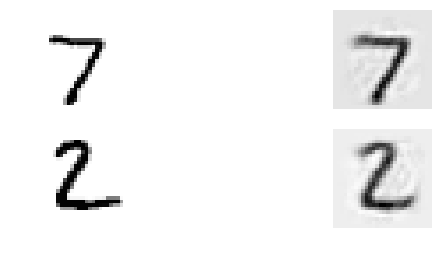

In [24]:
show_reconstructed_digits(inputs, outputs, './model/my_model_one_at_a_time.ckpt')

### 3.4 특성 시각화

INFO:tensorflow:Restoring parameters from ./model/my_model_one_at_a_time.ckpt


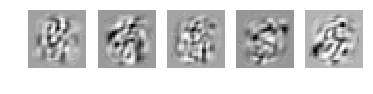

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./model/my_model_one_at_a_time.ckpt")
    W1_val = W1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(W1_val.T[i])

plt.show()

## 4. Stacked-오토인코더를 이용한 비지도 사전학습

대부분이 레이블되어 있지 않는 데이터셋이 있을 때, 먼저 전체 데이터를 사용해 stacked-오토인코더를 학습시킨다. 그런 다음 오토인코더의 하위 레이어를 재사용해 분류와 같은 실제 문제를 해결하기 위한 신경망을 만들고 레이블된 데이터를 사용해 학습시킬 수 있다.



![](./images/unsupervised.PNG)



위와 같은 방법을 텐서플로에서 구현할 때는 [Transfer Learning](http://excelsior-cjh.tistory.com/179?category=940399)포스팅에서 살펴본 방법과 같이 구현하면 된다. 이러한 비지도 사전학습 방법에 대한 소스코드는 [여기](https://github.com/rickiepark/handson-ml/blob/master/15_autoencoders.ipynb)에서 확인할 수 있다.

## 5. Denoising 오토인코더

오토인코더가 의미있는 특성(feature)을 학습하도록 제약을 주는 다른 방법은 입력에 노이즈(noise, 잡음)를 추가하고, 노이즈가 없는 원본 입력을 재구성하도록 학습시키는 것이다. 노이즈는 아래의 그림처럼 입력에 [가우시안(Gaussian) 노이즈](https://en.wikipedia.org/wiki/Gaussian_noise)를 추가하거나, 드롭아웃(dropout)처럼 랜덤하게 입력 유닛(노드)를 꺼서 발생 시킬 수 있다.



![denoising-autoencoder](./images/denoising.PNG)

### 5.1 텐서플로로 구현하기

이번에는 텐서플로를 이용해 가우시안 노이즈와 드롭아웃을 이용한 denoising-오토인코더를 구현해보도록 하자. 오토인코더 학습에 사용한 데이터셋은 위에서 부터 다뤘던 MNIST 데이터셋이다.

#### 5.1.1 Gaussian noise

In [26]:
reset_graph()

################
# layer params #
################
noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1
n_outputs = n_inputs

################
# train params #
################
learning_rate = 0.01
n_epochs = 10
batch_size = 150

# denoising autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
# add gaussian noise
inputs_noisy = inputs + noise_level * tf.random_normal(tf.shape(inputs))

hidden1 = tf.layers.dense(inputs_noisy, n_hidden1, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.layers.dense(hidden3, n_outputs, name='outputs')

# loss 
reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(reconstruction_loss)

# saver
saver = tf.train.Saver()

In [27]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('\repoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/my_model_stacked_denoising_gaussian.ckpt')

epoch : 0, Train MSE : 0.04464
epoch : 1, Train MSE : 0.03853
epoch : 2, Train MSE : 0.04359
epoch : 3, Train MSE : 0.04201
epoch : 4, Train MSE : 0.04067
epoch : 5, Train MSE : 0.04150
epoch : 6, Train MSE : 0.04232
epoch : 7, Train MSE : 0.04049
epoch : 8, Train MSE : 0.04413
epoch : 9, Train MSE : 0.04255


INFO:tensorflow:Restoring parameters from ./model/my_model_stacked_denoising_gaussian.ckpt


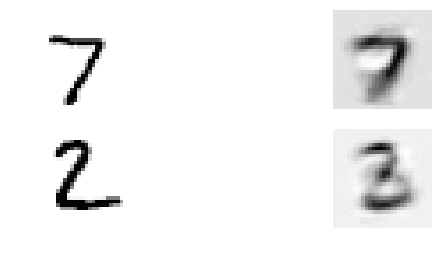

In [28]:
show_reconstructed_digits(inputs, outputs, './model/my_model_stacked_denoising_gaussian.ckpt')

#### 5.1.2 Dropout

In [29]:
reset_graph()

################
# layer params #
################
noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1
n_outputs = n_inputs

################
# train params #
################
dropout_rate = 0.3
learning_rate = 0.01
n_epochs = 10
batch_size = 150

training = tf.placeholder_with_default(False, shape=(), name='training')

# denoising autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
# add dropout
inputs_drop = tf.layers.dropout(inputs, dropout_rate, training=training)

hidden1 = tf.layers.dense(inputs_drop, n_hidden1, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.layers.dense(hidden3, n_outputs, name='outputs')

# loss 
reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(reconstruction_loss)

# saver
saver = tf.train.Saver()

In [30]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('\repoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/my_model_stacked_denoising_dropout.ckpt')

epoch : 0, Train MSE : 0.03542
epoch : 1, Train MSE : 0.02821
epoch : 2, Train MSE : 0.03197
epoch : 3, Train MSE : 0.02996
epoch : 4, Train MSE : 0.02990
epoch : 5, Train MSE : 0.02833
epoch : 6, Train MSE : 0.02964
epoch : 7, Train MSE : 0.02738
epoch : 8, Train MSE : 0.02957
epoch : 9, Train MSE : 0.02967


INFO:tensorflow:Restoring parameters from ./model/my_model_stacked_denoising_dropout.ckpt


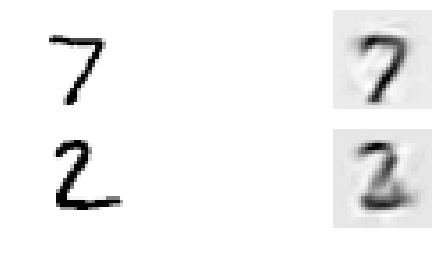

In [31]:
show_reconstructed_digits(inputs, outputs, './model/my_model_stacked_denoising_dropout.ckpt')

## 6. Sparse 오토인코더

오토인코더가 좋은 특성을 추출하도록 만드는 다른 제약 방법은 **희소성**(sparsity)를 이용하는 것인데, 이러한 오토인코더를 Sparse Autoencoder라고 한다. 이 방법은 손실함수에 적절한 항을 추가하여 오토인코더가 코딩층(coding layer, 가운데 층)에서 활성화되는 뉴런 수를 감소시키는 것이다. 예를들어 코딩층에서 평균적으로 5% 뉴런만 활성화되도록 만들어 주게 되면, 오토인코더는 5%의 뉴런을 조합하여 입력을 재구성해야하기 때문에 유용한 특성을 표현하게 된다.

이러한 Sparse-오토인코더를 만들기 위해서는 먼저 학습 단계에서 코딩층의 실제 sparse(희소) 정도를 측정해야 하는데, 전체 학습 배치(batch)에 대해 코딩층의 평균적인 활성화를 계산한다. 배치의 크기는 너무 작지 않게 설정 해준다. 

위에서 각 뉴런에 대한 평균 활성화 정도를 계산하여 구하고, 손실함수에 **희소 손실**(sparsity loss)를 추가하여 뉴런이 크게 활성화 되지 않도록 규제할 수 있다.  예를들어 한 뉴런의 평균 활성화가 `0.3`이고 목표 희소 정도가 `0.1`이라면, 이 뉴런은 **덜** 활성화 되도록 해야한다. 희소 손실을 구하는 간단한 방법으로는 제곱 오차 $(0.3 - 0.1)^{2}$를 추가하는 방법이 있다. 하지만, Sparse-오토인코더에서는 아래의 그래프 처럼 MSE보다 더 경사가 급한 쿨백 라이블러 발산(KL-divergense, Kullback-Leibler divergense)을 사용한다.

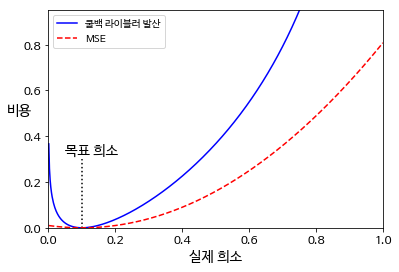

In [32]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "목표 희소", fontsize=14)
plt.plot(q, kl_div, "b-", label="쿨백 라이블러 발산")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("실제 희소")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95]);

### 6.1 쿨백 라이블러 발산

쿨백-라이블러 발산(Kullback-Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데 사용하는 함수이다. 예를들어 딥러닝 모델을 만들 때, 학습 데이터셋의 분포 $P(x)$와 모델이 추정한 데이터의 분포 $Q(x)$ 간에 차이를 KLD를 활용해 구할 수 있다([ratsgo's blog](https://ratsgo.github.io/statistics/2017/09/22/information/)).



$$
{ D }_{ KL }\left( P||Q \right) ={ E }_{ X\sim P }\left[ \log { \frac { P\left( x \right)  }{ Q(x) }  }  \right] ={ E }_{ X\sim P }\left[ \log { P(x) } -\log { Q(x) }  \right]
$$



Sparse-오토인코더에서는 코딩층에서 뉴런이 활성화될 목표 확률 $p$와 실제확률 $q$(학습 배치에 대한 평균 활성화) 사이의 발산을 측정하며, 식은 다음과 같다.


$$
D_{KL}\left( p||q \right) = p \log{\frac{p}{q}} + \left( 1- p \right) \log{\frac{1-p}{1-q}}
$$


위의 식을 이용해 코딩층의 각 뉴런에 대해 희소 손실을 구하고 이 손실을 모두 합한 뒤 희소 가중치 하이퍼파라미터를 곱하여 손실함수의 결과에 더해준다.
$$
Loss = \text{MSE} + \text{sparsity_weight} \times \text{sparsity_loss}
$$



### 6.2 텐서플로 구현

이번에는 텐서플로를 이용해 Sparse-오토인코더를 구현해보도록 하자. 

In [33]:
reset_graph()

################
# layer params #
################
noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 1000 # sparsity coding units
n_outputs = n_inputs

################
# train params #
################
sparsity_target = 0.1  # p
sparsity_weight = 0.2
learning_rate = 0.01
n_epochs = 20
batch_size = 1000

def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(inputs, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

# loss
hidden1_mean = tf.reduce_mean(hidden1, axis=0)  # 배치 평균  == q
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)
loss = reconstruction_loss + sparsity_weight * sparsity_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

In [37]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        recon_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, 
                                                                sparsity_loss,
                                                                loss], feed_dict={inputs: batch_x})
        print('\repoch : {}, Train MSE : {:.5f},'.format(epoch, recon_loss_val),
               'sparsity_loss : {:.5f}, total_loss : {:.5f}'.format(sparsity_loss_val, loss_val))
    saver.save(sess, './model/my_model_sparse.ckpt')

epoch : 0, Train MSE : 0.13765, sparsity_loss : 0.85285, total_loss : 0.30822
epoch : 1, Train MSE : 0.05900, sparsity_loss : 0.01139, total_loss : 0.06128
epoch : 2, Train MSE : 0.05303, sparsity_loss : 0.01861, total_loss : 0.05676
epoch : 3, Train MSE : 0.04821, sparsity_loss : 0.02690, total_loss : 0.05359
epoch : 4, Train MSE : 0.04416, sparsity_loss : 0.35537, total_loss : 0.11523
epoch : 5, Train MSE : 0.04137, sparsity_loss : 0.00702, total_loss : 0.04278
epoch : 6, Train MSE : 0.03740, sparsity_loss : 0.04587, total_loss : 0.04658
epoch : 7, Train MSE : 0.03650, sparsity_loss : 0.01669, total_loss : 0.03983
epoch : 8, Train MSE : 0.03361, sparsity_loss : 0.03076, total_loss : 0.03976
epoch : 9, Train MSE : 0.03046, sparsity_loss : 0.02792, total_loss : 0.03604
epoch : 10, Train MSE : 0.02842, sparsity_loss : 0.20959, total_loss : 0.07034
epoch : 11, Train MSE : 0.02572, sparsity_loss : 0.12303, total_loss : 0.05033
epoch : 12, Train MSE : 0.02338, sparsity_loss : 0.04348, tota

INFO:tensorflow:Restoring parameters from ./model/my_model_sparse.ckpt


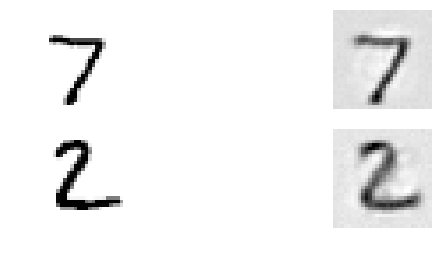

In [38]:
show_reconstructed_digits(inputs, outputs, "./model/my_model_sparse.ckpt")

## 7. Variational AutoEncoder (VAE)

**VAE**(Variational AutoEncoder)는 2014년 D.Kingma와 M.Welling이 [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114v10.pdf) 논문에서 제안한 오토인코더의 한 종류이다. VAE는 위에서 살펴본 오터인코더와는 다음과 같은 다른점이 있다.

- VAE는 **확률적 오토인코더**(probabilistic autoencoder)다. 즉, 학습이 끝난 후에도 출력이 부분적으로 우연에 의해 결정된다.
- VAE는 **생성 오토인코더**(generatie autoencoder)이며, 학습 데이터셋에서 샘플링된 것과 같은 새로운 샘플을 생성할 수 있다.

VAE의 구조는 아래의 그림과 같다.



![](./images/vae.PNG)



VAE의 코딩층은 다른 오토인코더와는 다른 부분이 있는데 주어진 입력에 대해 바로 코딩을 만드는 것이 아니라, 인코더(encoder)는 **평균 코딩** $\mu$와 **표준편차 코딩** $\sigma$ 을 만든다. 실제 코딩은 평균이 $\mu$이고 표준편차가 $\sigma$인 가우시안 분포(gaussian distribution)에서 랜덤하게 샘플링되며, 이렇게 샘플링된 코딩을 디코더(decoder)가 원본 입력으로 재구성하게 된다.

VAE는 마치 가우시안 분포에서 샘플링된 것처럼 보이는 코딩을 만드는 경향이 있는데, 학습하는 동안 손실함수가 코딩(coding)을 가우시안 샘플들의 집합처럼 보이는 형태를 가진 코딩 공간(coding space) 또는 **잠재 변수 공간**(latent space)로 이동시키기 때문이다. 

이러한 이유로 VAE는 학습이 끝난 후에 새로운 샘플을 가우시안 분포로 부터 랜덤한 코딩을 샘플링해 디코딩해서 생성할 수 있다.

### 7.1 VAE의 손실함수

VAE의 손실함수는 두 부분으로 구성되어 있다. 첫 번째는 오토인코더가 입력을 재구성하도록 만드는 일반적인 재구성 손실(reconstruction loss)이고, 두 번째는 가우시안 분포에서 샘플된 것 샅은 코딩을 가지도록 오토인코더를 제어하는 **latent loss**이다. 이 손실함수의 식에 대해서는 [ratsgo](https://ratsgo.github.io/generative%20model/2018/01/27/VAE/)님의 블로그를 참고하면 자세히 설명되어 있다. *(나도 언젠가 이해해서 포스팅할 날이 오기를...)*

### 7.2 텐서플로 구현

In [50]:
from functools import partial

reset_graph()

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

################
# train params #
################
learning_rate = 0.001
n_digits = 60
n_epochs = 50
batch_size = 150

initializer = tf.variance_scaling_initializer()
dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu, 
    kernel_initializer=initializer)


# VAE
inputs = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3_mean = dense_layer(hidden2, n_hidden3, activation=None) # mean coding
hidden3_sigma = dense_layer(hidden2, n_hidden3, activation=None)  # sigma coding
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)  # gaussian noise
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = dense_layer(hidden3, n_hidden4)
hidden5 = dense_layer(hidden4, n_hidden5)
logits = dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

# loss
eps = 1e-10  # NaN을 반환하는 log(0)을 피하기 위함
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=inputs, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

In [51]:
# train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, './model/my_model_variational.ckpt')
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        recon_loss_val, latent_loss_val, loss_val = sess.run([reconstruction_loss, 
                                                              latent_loss,
                                                              loss], feed_dict={inputs: batch_x})
        print('\repoch : {}, Train MSE : {:.5f},'.format(epoch, recon_loss_val),
               'latent_loss : {:.5f}, total_loss : {:.5f}'.format(latent_loss_val, loss_val))
    saver.save(sess, './model/my_model_variational.ckpt')
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from ./model/my_model_variational.ckpt
epoch : 0, Train MSE : 0.26063, latent_loss : 0.60576, total_loss : 0.86639
epoch : 1, Train MSE : 0.26151, latent_loss : 0.71757, total_loss : 0.97909
epoch : 2, Train MSE : 0.26771, latent_loss : 0.10973, total_loss : 0.37744
epoch : 3, Train MSE : 0.26688, latent_loss : 0.94755, total_loss : 1.21443
epoch : 4, Train MSE : 0.26177, latent_loss : 1.11834, total_loss : 1.38011
epoch : 5, Train MSE : 0.25747, latent_loss : 1.33966, total_loss : 1.59713
epoch : 6, Train MSE : 0.26622, latent_loss : 1.34273, total_loss : 1.60895
epoch : 7, Train MSE : 0.25730, latent_loss : 0.65787, total_loss : 0.91517
epoch : 8, Train MSE : 0.26304, latent_loss : 0.74869, total_loss : 1.01173
epoch : 9, Train MSE : 0.26854, latent_loss : 0.42567, total_loss : 0.69421
epoch : 10, Train MSE : 0.26288, latent_loss : 0.45869, total_loss : 0.72157
epoch : 11, Train MSE : 0.26179, latent_loss : 0.61457, total_loss : 0.87635
epoch : 12

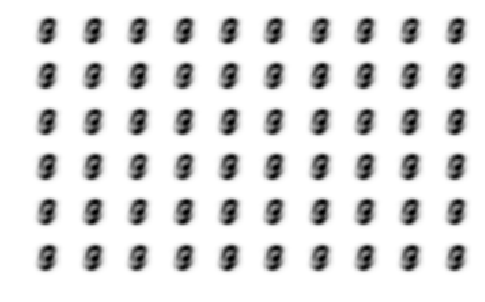

In [52]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

## 8. 마무리

이번 포스팅에서는 자기지도학습(self-supervised learning)인 오토인코더에 대해 개념과 uncomplete, stacked, denoising, sparse, VAE 오토인코더에 대해 알아보았다.